# Multi-Convolutional Sentiment Classifier

classifying IMDB reviews by their sentiment with a  concatenated *multiple parallel CNN* a.k.a. *Multi*-CNN.

#### Load dependencies 

In [16]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model #first time using it!
from keras.layers import Input, concatenate
from keras.layers import Dense, Dropout, Embedding
from keras.layers import Conv1D,SpatialDropout1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Set Hyperparameter 

In [2]:
# output directory name
output_dir = './model_output/multiconv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# Convolutional layer architecture
n_conv_1 = n_conv_2 = n_conv_3 = 256  #filter or kernels
k_conv_1 = 3  # kernel length
k_conv_2 = 2
k_conv_3 = 4

# dense layer architecture:
n_dense = 256
dropout = 0.2

#### Load data 

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess data 

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design NN Architecture

In [23]:
# totally new
input_layer = Input(shape=(max_review_length,), dtype='int16', name='input') # supports integers +/- 32.7k 

# embedding_layer =  Embedding(...)(input_layer)
# annotating input_layer within a set of parenthesis, an interesting way of doing it! 
embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_review_length, name='embedding')(input_layer)

drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

# the following 3 layers are in parallel and their output will be concatenated
conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# concatenating maxpooling layers to pass as input to next layer, dense_layer
concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)

# adding second dense layer
dense_layer_2 = Dense(64, activation='relu', name='dense_layer_2')(drop_dense_layer)
drop_dense_layer_2 = Dropout(dropout, name='drop_dense_layer_2')(dense_layer_2)

predictions = Dense(1, activation='sigmoid', name='output')(drop_dense_layer_2)

model = Model(input_layer, predictions)

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 400)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
__________________________________________________________________________________________________
conv_2 (Co

#### configure model 

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train! 

In [31]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 35s 1ms/step - loss: 0.4859 - acc: 0.7343 - val_loss: 0.2976 - val_acc: 0.8753
Epoch 2/4
25000/25000 [==============================] - 29s 1ms/step - loss: 0.2386 - acc: 0.9060 - val_loss: 0.2576 - val_acc: 0.8935
Epoch 3/4
25000/25000 [==============================] - 29s 1ms/step - loss: 0.1741 - acc: 0.9357 - val_loss: 0.2661 - val_acc: 0.8944
Epoch 4/4
25000/25000 [==============================] - 29s 1ms/step - loss: 0.1154 - acc: 0.9598 - val_loss: 0.3326 - val_acc: 0.8858


#### Evaluate 

In [9]:
model.load_weights(output_dir+'/weights.01.hdf5')

In [10]:
y_hat = model.predict(x_valid)

In [11]:
y_hat[0]

array([0.09244329], dtype=float32)

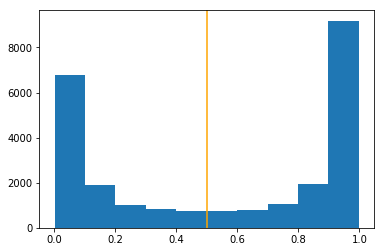

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [14]:
"{:0.2f}".format(pct_auc)

'95.09'